## Project 1

In the STARR-seq analysis we performed Module 7, we ended by plotting boxplots for STARR-seq scores of each motif that was enriched in enhancers activated by ecdysone compared to constitutive enhancers. Write code to compare those scores against STARR-seq scores for the same motifs found in enhancers in the absence of ecdysone. This would be the output:
<img src='boxplot_compare.png'>

The suffix "_wo" means those boxplots correspond to enhancers with the corresponding motifs found in the STARR-seq dataset without ecdysone treatment.

3L
3L
              # motif_id
motif_alt_id            
Abd-B           0.008268
Antp            0.007516
B-H1            0.013529
B-H2            0.013529
BEAF-32         0.006764
              # motif_id
motif_alt_id            
Abd-B           0.010872
Antp            0.008292
B-H1            0.013820
B-H2            0.013820
BEAF-32         0.009766


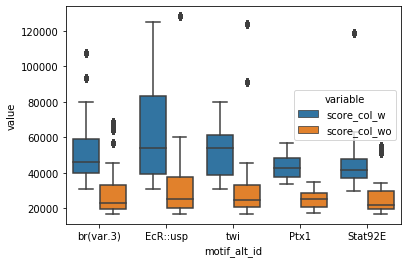

In [28]:
import scipy
from scipy.signal import find_peaks
from numpy import pi
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import seaborn as sns
import matplotlib.pyplot as plt

def readwig (inFile):
  wig=open(inFile, 'r' )
  val={}
  for line in wig:
    lineL = line.split()
    if "chr" in lineL[1]:
      cj=lineL[1]
      chrom=cj[9:]
      print(chrom)
      val.setdefault(chrom,{})
    elif "rack" not in line:
      pos=int(lineL[0])
      val[chrom][pos] = float(lineL[1])
  return(val)

w_ecd = readwig('3L.w_ecd.wig')
wo_ecd = readwig('3L.wo_ecd.wig')

#let us apply this to the whole chromosome

temp_listw = [] #Values
pos_list = [] #Chromosome positions

for i in sorted(w_ecd['3L'].keys()):
    temp_listw.append(w_ecd['3L'][i])
    pos_list.append(i)

chrom_array = np.array(temp_listw)

smooth_ar = savgol_filter(chrom_array,9,1)
peaks_ecd, _ = find_peaks(smooth_ar, height=4*smooth_ar.std()+smooth_ar.mean(), distance=10)

#Now for the non ecdysone treated sample

temp_listwo = []
pos_list_wo = []

for i in sorted(wo_ecd['3L'].keys()):
    temp_listwo.append(wo_ecd['3L'][i])
    pos_list_wo.append(i)

chrom_array_wo = np.array(temp_listwo)

smooth_ar_wo = savgol_filter(chrom_array_wo,9,1)
peaks_wo_ecd, _ = find_peaks(smooth_ar_wo, height=4*smooth_ar_wo.std()+smooth_ar_wo.mean(), distance=10)

#peak vals
rand_index = int(np.random.rand()*len(peaks_ecd)-1)
peak_val = pos_list[peaks_ecd[rand_index]]

rand_indexwo = int(np.random.rand()*len(peaks_wo_ecd)-1)
peak_valwo = pos_list_wo[peaks_wo_ecd[rand_index]]

#dictionaries
peak_score_w_ecd = {}
peak_score_wo_ecd = {}

wh = open("py_peaks_w_ecd.bed","w")
ave_vals = {}
location = []
for p in peaks_ecd:
    peak_pos = pos_list[p]
    temp_str = "chr3L\t" + str(peak_pos-250) + "\t" + str(peak_pos+250) + "\t" + str(p) + "\n"
    wh.write(temp_str)
    for i in range(peak_pos-2000,peak_pos+2000):
        if i in w_ecd['3L']:
            ave_vals.setdefault('val',{})
            if i-peak_val in ave_vals:
                ave_vals['val'][i-peak_pos] += w_ecd['3L'][i]
            else:
                ave_vals['val'][i-peak_pos] = w_ecd['3L'][i]
    score=0
    key="chr3L:" + str(peak_pos-250) + "-" + str(peak_pos+250)
    for i in range(peak_pos-100,peak_pos+100):
        if i in w_ecd['3L']:
            score+=w_ecd['3L'][i]
        peak_score_w_ecd[key] = score/20
wh.close()

woh = open("py_peaks_wo_ecd.bed","w")
ave_valswo = {}
locationwo = []
for p in peaks_wo_ecd:
    peak_pos = pos_list_wo[p]
    temp_str = "chr3L\t" + str(peak_pos-250) + "\t" + str(peak_pos+250) + "\t" + str(p) + "\n"
    woh.write(temp_str)
    for i in range(peak_pos-2000,peak_pos+2000):
        if i in wo_ecd['3L']:
            ave_valswo.setdefault('val',{})
            if i-peak_valwo in ave_valswo:
                ave_valswo['val'][i-peak_pos] += wo_ecd['3L'][i]
            else:
                ave_valswo['val'][i-peak_pos] = wo_ecd['3L'][i]
    score=0
    key="chr3L:" + str(peak_pos-250) + "-" + str(peak_pos+250)
    for i in range(peak_pos-100,peak_pos+100):
        if i in wo_ecd['3L']:
            score+=wo_ecd['3L'][i]
        peak_score_wo_ecd[key] = score/20
woh.close()

#print(peak_score_w_ecd)

#print(peak_score_wo_ecd)

w_ecd_motifs = pd.read_csv('fimo_w_ecd.txt',sep='\t')
#w_ecd_motifs.head()

wo_ecd_motifs = pd.read_csv('fimo_wo_ecd.txt',sep='\t')
#wo_ecd_motifs.head()

norm_w_ecd = (w_ecd_motifs.groupby('motif_alt_id').count()/len(w_ecd_motifs)).iloc[:,0:1]
norm_wo_ecd = (wo_ecd_motifs.groupby('motif_alt_id').count()/len(wo_ecd_motifs)).iloc[:,0:1]
print(norm_w_ecd.head())
print(norm_wo_ecd.head())
mergeddf = pd.merge(norm_w_ecd, norm_wo_ecd, how = 'left', on = 'motif_alt_id')
#mergeddf.head()

ratio_w  = mergeddf['# motif_id_x']
ratio_wo = mergeddf['# motif_id_y']

Enrichment = (ratio_w / ratio_wo)

newdf = mergeddf.assign(Enrichment = Enrichment)
#print(newdf.sort_values(by='Enrichment',ascending=False).head())

#scoretest = peak_score_w_ecd[w_ecd_motifs.iloc[0]['sequence_name']]
#scoretest

with_score = pd.DataFrame()
for i in newdf.sort_values(by='Enrichment',ascending=False).head(5).index.values:
    new_df = w_ecd_motifs.query("motif_alt_id == '{0}'".format(i)).iloc[:,1:3]
    score_col = []
    for index, row in new_df.iterrows():
        score_col.append(peak_score_w_ecd[row['sequence_name']])
    new_df = new_df.assign(score_col = score_col)
    with_score = with_score.append(new_df)


without_score = pd.DataFrame()
for i in newdf.sort_values(by='Enrichment',ascending=False).head(5).index.values:
    new_df = wo_ecd_motifs.query("motif_alt_id == '{0}'".format(i)).iloc[:,1:3]
    score_col = []
    for index, row in new_df.iterrows():
        score_col.append(peak_score_wo_ecd[row['sequence_name']])
    new_df = new_df.assign(score_col = score_col)
    without_score = without_score.append(new_df)
#without_score.head()
#with_score.head()

mergewwo = pd.merge(with_score, without_score, how = 'outer', on = 'motif_alt_id', suffixes = ['_w', '_wo'])
#mergewwo
meltedmergewwo = pd.melt(mergewwo, id_vars = ['motif_alt_id'], value_vars = ['score_col_w', 'score_col_wo'])
meltedmergewwo


#plot
sns.boxplot(data = meltedmergewwo, x = 'motif_alt_id', y = 'value', hue = 'variable')
plt.show()

## Project 2

For the ecdysone responsive enhancers, we want to find out if adjacent genes change during ecdysone treatment. Gene expression changes upon addition of ecdysone is in the file "rpkm_ecdysone_to_ctl.txt", which has two columns separated by a tab. First column is Gene_name, second column named "Enrichment" is the log2 fold change of expression upon addition of ecdysone. The genes next to enhancers responsive to ecdysone are listed in "w_ecd_genes.list" and the control group is listed in "wo_ecd_genes.list". Make a boxplot of expression change comparing genes next to ecdysone enhancers and genes next to control enhancers. Your result should look like this:

<img src='gene_exp_boxplot.png'>

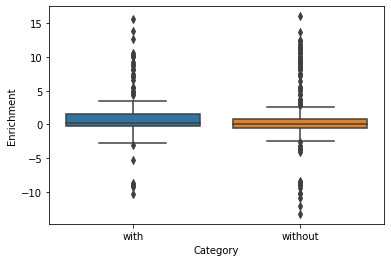

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


rpkmfile = pd.read_csv("rpkm_ecdysone_to_ctl.txt",sep='\t')
wlist = pd.read_csv("w_ecd_genes.list")
wolist = pd.read_csv("wo_ecd_genes.list")

#set(wlist) & set(wolist) #ok, the lists are mutually exclusive so each gene is either w or wo 

wlist['Category']='with'
wolist['Category']='without'

wwo = wlist.append(wolist, ignore_index = True)
#print(wwo)

merged = pd.merge(wwo, rpkmfile, how = "left", on = "Gene_name")
merged

sns.boxplot(data = merged, x = 'Category', y = 'Enrichment')
plt.show()

## Project 3

RBFOX2 is a human splicing factor.  It regulates the inclusion of exons through binding to specific RNA sites near alternative exons.  Below is a "splicing map" from Jangi et al (2014) for RBFOX2.  It combines RBP/RNA interaction data (CLIP-seq) with data about which exons are more/less included upon RBFOX2 knockdown.

![RBFOXmap.png](RBFOXmap.png)

As you can see, exons whose inclusion is enhanced (green line) tend to have RBFOX2 bound in the intron immediately downstream of the exon.  This indicates that RBFOX2 likely promotes inclusion of this exon by binding in the downstream intron.  

We might wonder how RBFOX2 knows to bind these specific introns.  We know that RNA-binding proteins like RBFOX2 often recognize their RNA targets through interaction with short RNA sequences (kmers).  Perhaps, then, RBFOX2 is recognizing a specific kmer that is enriched in the introns downstream of the exons it enhances.  Can we figure out what this kmer (or kmers) might be?

One way to do this would be by comparing two groups of sequences.  One group could be sequences from introns downstream of exons whose inclusion is enhanced by RBFOX2.  Think of these as the "affected" exons.  The other group could be sequences from the same downstream intron, but only after exons whose inclusion is unaffected by RBFOX2. Think of these as the "control" exons.  

*As an aside, we know which exons are enhanced by RBFOX2 and which are not by analyzing splicing transcriptome-wide in cells that we treated with either RBFOX2 siRNA or control siRNA.*

We would expect that the kmer that RBFOX2 is recognizing would be enriched in introns downstream of "affected" exons relative to the introns downstream of "control" exons.  It just so happens that we have made fasta files containing intronic sequences downstream of both exon classes.  You can download them from the links below.

[Enhanced](https://github.com/srinivasramachandran/Anschutz_python/blob/master/DownstreamIntron.Enhanced.fasta)

[Control](https://github.com/srinivasramachandran/Anschutz_python/blob/master/DownstreamIntron.Control.fasta)

> For the splicing afficionados out there, these files are actually of the last 50 nt of each exon and the first 150 nt of the downstream intron.

What we would like to do is write code that compares the sequence content of the two files and identifies 5-mers that are enriched in the "Enhanced" file relative to the "control" file.  This can be done with the following approach:

1\.  Go through each file and count the number of occurences of each 5-mer.  This might be best stored as a dictionary of the form {kmer : number of occurences}.

2\.  Calculate a log2 enrichment for each for each kmer in the affected relative to control by dividing the frequency of the kmer in the affected sequences to its frequency in control sequences and taking the log base 2 of the ratio.  Remember that the frequency of a kmer is that number of occurences of that kmer divided by the number of occurences of all kmers.  Frequencies must be between 0 and 1.  Enrichments will be positive if the kmer is enriched in the enhanced sequences and negative if enriched in the control sequences.

3\.  Calculate the statistical significance of that enrichment with a Fisher's exact test.  This can be done by importing the fisher_exact function from the scipy.stats module.  See the [documentation](http://lagrange.univ-lyon1.fr/docs/scipy/0.17.1/generated/scipy.stats.fisher_exact.html) for fisher_exact for help.

 As you can see from it's documentation, for each kmer, fisher_exact is expecting a 2x2 contingency table of kmer counts.  For your data, this is of the form:

|         |controlseqs|enhancedseqs|
|---------|-----------|------------|
|counts of this kmer| a | b|
|combined counts of all other kmers|c|d|

 fisher_exact is expecting to be given this table in the form of the nested list 
 > [[a, b], [c, d]]

 It will return two values.  You only want one of the two.  Make sure you choose the right one.


4\. Correct your Fisher's exact p-values for multiple hypothesis testing with a Bonferroni correction.  Very simply, multiply your original pvalue from fisher_exact by the number of kmers you are considering (there are 1024 possible 5mers).

5\. Sort kmers by their corrected pvalues.

6\. Write a file with the following columns for every kmer:
      kmer, frequency_in_enhanced, frequency_in_ctrl, enrichment (log2), uncorrected pvalue, corrected pvalue
      
7\. Print the first 10 lines (the top 10 kmers sorted by pvalue) in your code block.      

Perhaps the best way to tackle this would be to write an independent function for each one of the numbered tasks above.  This keeps your code neat and readable.

In [15]:
enh = open("DownstreamIntron.Enhanced.fasta", "r")
ctrl = open("DownstreamIntron.Control.fasta", "r")

enhseq = []
for line in enh: #for each line
    if line.startswith('>'): #Does the line start with the ">" symbol?
        seq_name = line
    else:
        enhseq.append(line)
#print(enhseq)

#enhseq looks good but we need to get rid of those "\n" things at the end of every seq 

eklist = []
for seq in enhseq:
    for i in range(0,(len(seq)-6)): #-6 and not -4 to also eliminate the darn '/n's
        eklist.append(seq[i]+seq[i+1]+seq[i+2]+seq[i+3]+seq[i+4])
#print(eklist)

ekmers={}
for i in eklist:
    ekmers.setdefault(i, 0) 
    ekmers[i]+=1
print(ekmers)

#now for control dictionary
conseq = []
for line in ctrl: #for each line
    if line.startswith('>'): #Does the line start with the ">" symbol?
        seq_name = line
    else:
        conseq.append(line)

conlist = []
for seq in conseq:
    for i in range(0,(len(seq)-6)): #-6 and not -4 to also eliminate the darn '/n's
        conlist.append(seq[i]+seq[i+1]+seq[i+2]+seq[i+3]+seq[i+4])

conkmers={}
for i in conlist:
    conkmers.setdefault(i, 0) 
    conkmers[i]+=1
print(conkmers)


enh.close()
ctrl.close()


{'AAAGC': 138, 'AAGCT': 157, 'AGCTA': 86, 'GCTAC': 59, 'CTACA': 95, 'TACAC': 78, 'ACACA': 148, 'CACAT': 125, 'ACATC': 86, 'CATCA': 131, 'ATCAC': 94, 'TCACT': 156, 'CACTT': 175, 'ACTTG': 132, 'CTTGA': 162, 'TTGAC': 88, 'TGACA': 122, 'GACAC': 93, 'ACACC': 100, 'CACCA': 140, 'ACCAT': 113, 'CCATA': 80, 'CATAC': 58, 'ATACA': 120, 'CCATC': 129, 'CATCT': 137, 'ATCTT': 151, 'TCTTG': 184, 'CTTGG': 190, 'TTGGT': 189, 'TGGTT': 176, 'GGTTA': 62, 'GTTAC': 70, 'TTACA': 126, 'TACAT': 112, 'ACATA': 111, 'CATAA': 106, 'ATAAT': 153, 'TAATG': 167, 'AATGA': 170, 'ATGAA': 189, 'TGAAG': 204, 'GAAGG': 178, 'AAGGT': 199, 'AGGTG': 264, 'GGTGA': 253, 'GTGAT': 142, 'TGATC': 94, 'GATCA': 98, 'ATCAA': 103, 'TCAAC': 65, 'CAACA': 108, 'AACAA': 137, 'ACAAA': 150, 'CAAAT': 144, 'AAATG': 259, 'AATGT': 205, 'ATGTT': 203, 'TGTTT': 360, 'GTTTG': 175, 'TTTGT': 330, 'TTGTT': 248, 'TGTTG': 187, 'GTTGA': 106, 'TTGAA': 211, 'TGAAA': 254, 'GAAAT': 206, 'AAATA': 254, 'AATAT': 200, 'ATATA': 182, 'TATAA': 138, 'ATAAA': 211, 'TAAAC

{'ATGCC': 1083, 'TGCCC': 1772, 'GCCCC': 1507, 'CCCCC': 1318, 'CCCCA': 1953, 'CCCAG': 2766, 'CCAGT': 1395, 'CAGTT': 1623, 'AGTTG': 1288, 'GTTGA': 1011, 'TTGAG': 1553, 'TGAGC': 1558, 'GAGCT': 1441, 'AGCTA': 902, 'GCTAC': 590, 'CTACA': 965, 'TACAG': 1615, 'ACAGC': 1265, 'CAGCT': 1942, 'AGCTT': 1526, 'GCTTC': 1387, 'CTTCT': 2302, 'TTCTT': 3274, 'TCTTC': 2076, 'CTTCA': 1769, 'TTCAC': 1307, 'TCACG': 358, 'CACGA': 233, 'ACGAA': 203, 'CGAAT': 193, 'GAATG': 1325, 'AATGT': 1781, 'ATGTA': 1424, 'TGTAG': 1164, 'GTAGT': 773, 'TAGTC': 568, 'AGTCC': 936, 'GTCCC': 1106, 'TCCCA': 1974, 'CCAGC': 1986, 'CAGCC': 2094, 'AGCCA': 1721, 'GCCAG': 1875, 'CCAGG': 2880, 'CAGGT': 2835, 'AGGTG': 2567, 'GGTGA': 2233, 'GTGAG': 2559, 'TGAGT': 1964, 'GAGTC': 1047, 'GTCCA': 862, 'TCCAG': 1907, 'CCAGA': 1747, 'CAGAT': 1458, 'AGATG': 1651, 'GATGA': 1306, 'ATGAC': 881, 'TGACT': 1355, 'GACTG': 1169, 'ACTGC': 1167, 'CTGCC': 2273, 'TGCCT': 2097, 'GCCTG': 2084, 'CCTGG': 2763, 'CTGGC': 1777, 'TGGCT': 2060, 'GGCTC': 1356, 'GCTCT

## Project 4

RNA molecules, being single stranded, have the ability to fold onto themselves into elaborate secondary structures by forming basepairs between nucleotides. These structures are often important for the biological function of the RNA.  Several modern algorithms exist for predicting RNA secondary structures from a given primary sequence.  One of these is called RNAfold.  When RNAfold is given the sequence of a noncoding RNA called 7SK (sequence below, make sure you scroll right),

>GGAUGUGAGGGCGAUCUGGCUGCGACAUCUGUCACCCCAUUGAUCGCCAGGGUUGAUUCGGCUGAUCUGGCUGGCUAGGCGGGUGUCCCCUUCCUCCCUCACCGCUCCAUGUGCGUCCCUCCCGAAGCUGCGCGCUCGGUCGAAGAGGACGACCAUCCCCGAUAGAGGAGGACCGGUCUUCGGUCAAGGGUAUACGAGUAGCUGCGCUCCCCUGCUAGAACCUCCAAACAAGCUCUCAAGGUCCAUUUGUAGGAGAACGUAGGGUAGUCAAGCUUCCAAGACUCCAGACACAUCCAAAUGAGGCGCUGCAUGUGGCAGUCUGCCUUUCUUUU

it predicts the following structure to be its most thermodynamically favored:

![7skstructure.png](7skstructure.png)

However, this is just one of many possible structures for this sequence. We might want to more accurately represent the whole ensemble of possible structures.  That is what we will do here.  During its computation, one of the things that RNAfold computes is the probability with each base is paired with every other base.  This is output as part of a text file.  That file for 7SK is [here](https://github.com/srinivasramachandran/Anschutz_python/blob/master/7skbpprob.txt).

Download this file. Parse it to get the basepairing probabilities for every possible nucleotide-nucleotide pair.  In this file, the base pair probability data begins with the line "%start of base pair probability data".  Every line after that contains four fields and is of the following form:

-------------------
position1 | position2 | **sqrt**(probability that position1 and position2 pair) | 'ubox'

-------------------

Probabilities of course range between 0 and 1. You will notice that not all possible pairs are listed in the file.  This could be for one of two reasons:

1. The probability that baseX and baseY interact is 0.
2. The probability that baseX and baseY interact has already been listed.  For example, position 1 and position 106 are listed as having an interaction probability of 0.003714731<sup>2</sup>.  The interaction between position 106 and position 1 will not be listed because it is the same as this and therefore redundant.

Construct a table that efficiently stores all of the basepair interaction data.  One possible structure is to have both column names (i) and row names (indicies) (j) be positions, and the value at i,j be their interaction probability.  

Perhaps the most efficient way to do this is to end up with a dictionary of the form {position : [list of all probabilities to other bases, IN THE ORDER OF THEIR POSITION]}.  This dictionary could be easily imported into a pandas dataframe. As a sanity check, in this dataframe, you can make sure that the probability at i,j is the same as the probability at j,i.

Using this table, make 2 plots.


### Plot 1

Plot the basepair probabilties as a heatmap where the rows and columns are positions, in order, and the color of the tile is the probability that the two positions are paired.  The [documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for seaborn heatmaps may be useful.


### Plot 2

For each position, plot the sum of all of the probabilities across all other positions.  This will be the probability that this position is paired at all.  Perhaps a [seaborn lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html) would fit this data well. 



In [15]:
f = open('7skbpprob.txt', 'r' )
lines = f.readlines()

In [18]:
target_ind = lines.index("%start of base pair probability data\n")
new_lines = lines[target_ind:-3]